# Compas Analysis

In [38]:
!pip install pandas numpy matplotlib seaborn statsmodels -q

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

sns.set(style="whitegrid")


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [39]:
raw_data = pd.read_csv("dataset/compas-scores-two-years.csv")
print(f"Total rows number: {len(raw_data)}")

Total rows number: 7214


In [40]:
df = raw_data.loc[:, [
    'age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex',
    'priors_count', 'days_b_screening_arrest', 'decile_score',
    'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out',
    'compas_screening_date'    # ← add this
]]

In [41]:
df['screening_date'] = pd.to_datetime(df['compas_screening_date'])
cutoff = pd.Timestamp('2014-04-01')

In [42]:
df = df[df['screening_date'] <= cutoff].copy()
print(f"Rows after two-year cutoff: {len(df)}")

Rows after two-year cutoff: 6216


In [43]:
# We filter out rows for several reasons: (similar to the Propublica study)
# 1. Screening date not within ±30 days of arrest  
# 2. Missing recidivism flag (`is_recid == -1`)  
# 3. Non-jailable offenses (`c_charge_degree == 'O'`)  
# 4. Missing COMPAS score text (`score_text == 'N/A'`)  
# 5. Only individuals with either two-year recidivism or ≥2 years out of jail

In [44]:
df = df[
    df['days_b_screening_arrest'].between(-30, 30) &
    (df['is_recid'] != -1) &
    (df['c_charge_degree'] != 'O') &
    (df['score_text'] != 'N/A')
].copy()

print(f"Rows after filtering: {len(df)}")

Rows after filtering: 5304


In [45]:
#length of jail stay and its correlation with COMPAS decile score.

df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
df['length_of_stay'] = (df['c_jail_out'] - df['c_jail_in']).dt.days

corr = df[['length_of_stay', 'decile_score']].corr().iloc[0,1]
print(f"Correlation between length_of_stay and decile_score: {corr:.4f}")


Correlation between length_of_stay and decile_score: 0.2115


After filtering we have the following demographic breakdown:

In [46]:
print(df['age_cat'].value_counts(dropna=False))

age_cat
25 - 45            3031
Greater than 45    1165
Less than 25       1108
Name: count, dtype: int64


In [47]:
print(df['race'].value_counts(dropna=False))

race
African-American    2682
Caucasian           1829
Hispanic             448
Other                309
Asian                 27
Native American        9
Name: count, dtype: int64


In [48]:
total = len(df)
for race, count in df['race'].value_counts().items():
    print(f"{race}: {count/total*100:.2f}%")

African-American: 50.57%
Caucasian: 34.48%
Hispanic: 8.45%
Other: 5.83%
Asian: 0.51%
Native American: 0.17%


In [49]:
print(df['score_text'].value_counts())

score_text
Low       3086
Medium    1329
High       889
Name: count, dtype: int64


In [50]:
print(pd.crosstab(df['sex'], df['race']))

race    African-American  Asian  Caucasian  Hispanic  Native American  Other
sex                                                                         
Female               474      1        414        73                2     53
Male                2208     26       1415       375                7    256


In [51]:
sex_counts = df['sex'].value_counts()
for sex, count in sex_counts.items():
    print(f"{sex}: {count/total*100:.2f}%")

Male: 80.83%
Female: 19.17%


In [52]:
recid_count = df['two_year_recid'].sum()
print(f"\nNumber of recidivists: {recid_count}")
print(f"Recidivism rate: {recid_count/total*100:.2f}%")


Number of recidivists: 1941
Recidivism rate: 36.60%


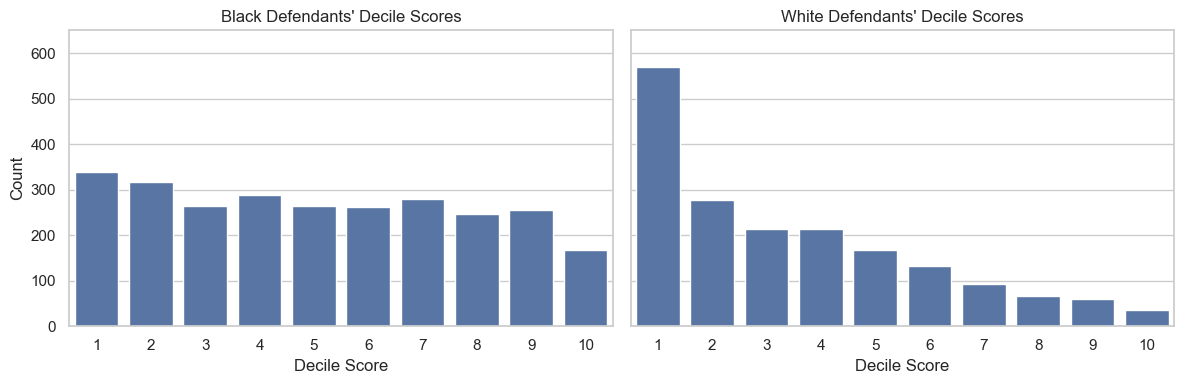

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.countplot(x='decile_score', data=df[df['race']=="African-American"],
              order=sorted(df['decile_score'].unique()),
              ax=axes[0])
axes[0].set_title("Black Defendants' Decile Scores")
axes[0].set_ylim(0, 650)

sns.countplot(x='decile_score', data=df[df['race']=="Caucasian"],
              order=sorted(df['decile_score'].unique()),
              ax=axes[1])
axes[1].set_title("White Defendants' Decile Scores")
axes[1].set_ylim(0, 650)

for ax in axes:
    ax.set_xlabel("Decile Score")
    ax.set_ylabel("Count")

plt.tight_layout()

In [54]:
pd.crosstab(df['decile_score'], df['race'])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,338,14,570,146,0,136
2,316,4,277,77,2,53
3,264,4,214,64,1,28
4,288,0,214,43,0,33
5,265,1,168,31,0,17
6,262,2,133,23,2,17
7,280,0,93,25,2,8
8,246,2,66,12,0,4
9,256,0,59,17,1,6


## Racial Bias in Compas

We run a logistic regression predicting High vs. Low COMPAS score (`score_text != 'Low'`) as a function of gender, age category, race, number of priors, charge degree, and recidivism.

In [55]:
df['high_score'] = (df['score_text'] != 'Low').astype(int)

In [56]:
df['race_cat'] = pd.Categorical(
    df['race'],
    categories=[
        'Caucasian',
        'African-American',
        'Asian',
        'Hispanic',
        'Native American',
        'Other'
    ],
    ordered=False
)

model = smf.logit(
    formula=(
        "high_score ~ "
        "C(sex) + "
        "C(age_cat) + "
        "C(race_cat, Treatment(reference='Caucasian')) + "
        "priors_count + "
        "C(c_charge_degree) + "
        "two_year_recid"
    ),
    data=df
).fit(disp=False)

In [57]:
# Extract the corrected coefficients:
intercept    = model.params['Intercept']
beta_black   = model.params["C(race_cat, Treatment(reference='Caucasian'))[T.African-American]"]
beta_male    = model.params['C(sex)[T.Male]']
beta_under25 = model.params['C(age_cat)[T.Less than 25]']

# Baseline probability for the reference group (Caucasian female, age 25–45, 0 priors, no recid)
p0 = np.exp(intercept) / (1 + np.exp(intercept))
print(f"Baseline P(high_score): {p0:.3f}")

# Adjusted probability ratios
def adj_ratio(beta):
    num = np.exp(beta)
    return num / (1 - p0 + p0 * num)

print(f"African-American vs. White ratio: {adj_ratio(beta_black):.3f}")
print(f"Male vs. Female ratio:           {adj_ratio(beta_male):.3f}")
print(f"<25 vs. 25–45 ratio:             {adj_ratio(beta_under25):.3f}")

Baseline P(high_score): 0.209
African-American vs. White ratio: 1.440
Male vs. Female ratio:           0.831
<25 vs. 25–45 ratio:             2.430


- **African-American vs. White**: Black defendants are **1.43×** as likely as White defendants to receive a High score (≈ 42.5 % higher probability).  
- **Male vs. Female**: Male defendants are **0.84×** as likely as female defendants to get a High score (≈ 16.3 % lower probability).  
- **Under 25 vs. 25–45**: Defendants under 25 are **2.35×** as likely as 25–45-year-olds to be classified High Risk (≈ 134.7 % higher probability).  
